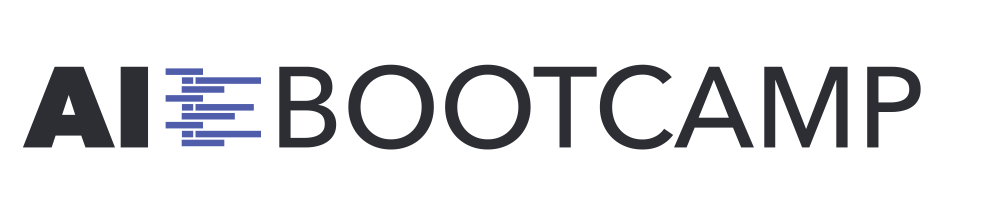

#House Pricing Demo

In this demo, we will walk through the hous pricing learning model from the supervised learning lecture. As a reminder, our goal is to design a model that will take in a house alongside its features as input and returns the projected price for that house. This is a regression task as discussed in lecture and here, we will deploy a linear regression model for this task.

Author: Thierno Diallo

##Data Loading

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Download dataset
!pip install kaggle
!kaggle datasets download -d yasserh/housing-prices-dataset

Dataset URL: https://www.kaggle.com/datasets/yasserh/housing-prices-dataset
License(s): CC0-1.0
  0% 0.00/4.63k [00:00<?, ?B/s]
100% 4.63k/4.63k [00:00<00:00, 9.85MB/s]


In [3]:
# Open dataset and save as data
with zipfile.ZipFile("/content/housing-prices-dataset.zip", "r") as zf:
  zf.extractall("/content")
df = pd.read_csv("/content/Housing.csv")
data = df

###Data Visualization

Here we will examine our dataset and visualize it to better understand it.

In [4]:
df.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

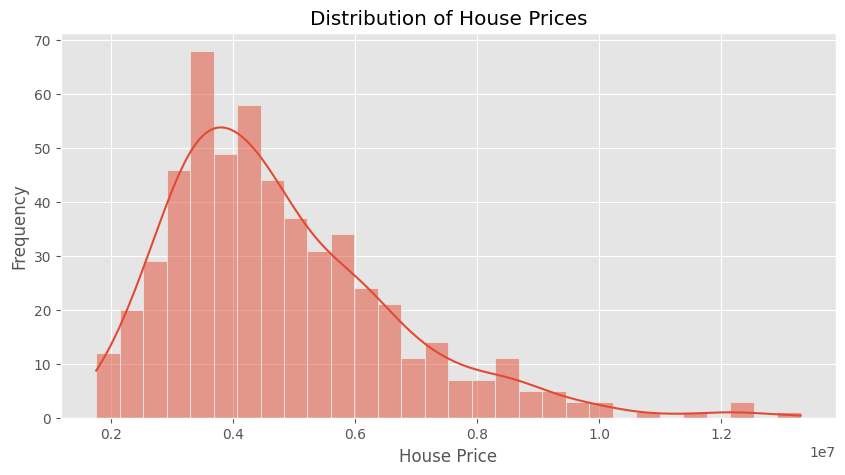

In [5]:
# Set plot style
plt.style.use("ggplot")

# 1. Distribution of House Prices
plt.figure(figsize=(10, 5))
sns.histplot(df["price"], bins=30, kde=True)
plt.xlabel("House Price")
plt.ylabel("Frequency")
plt.title("Distribution of House Prices")
plt.show()

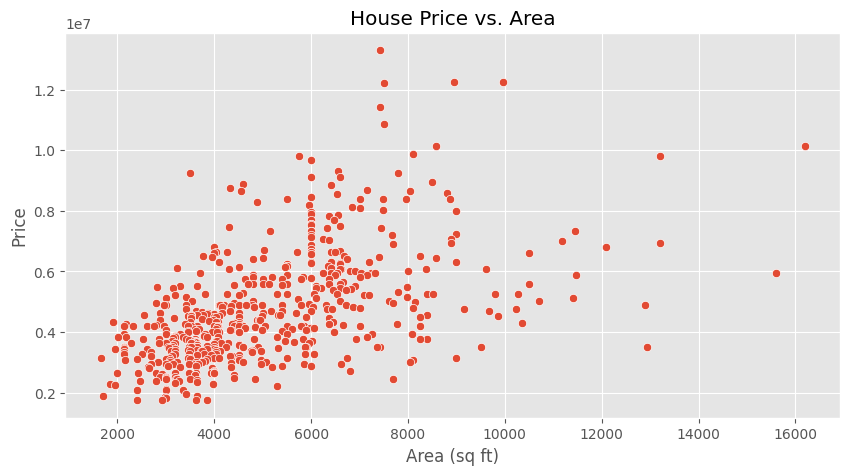

In [6]:
# 2. Relationship Between Area and Price
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df["area"], y=df["price"])
plt.xlabel("Area (sq ft)")
plt.ylabel("Price")
plt.title("House Price vs. Area")
plt.show()

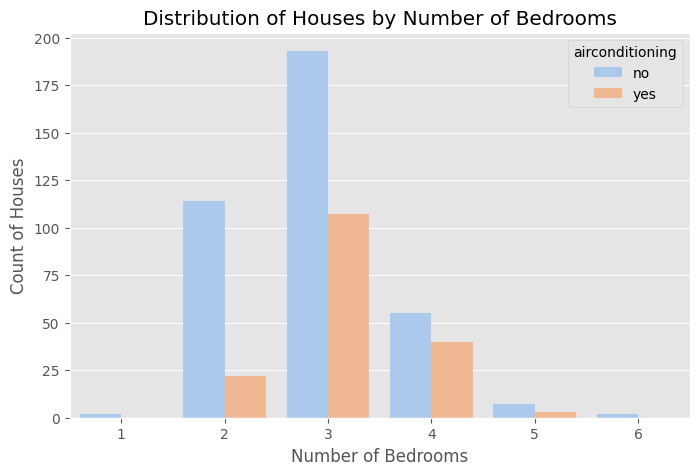

In [7]:
# 3. Count of Houses by Number of Bedrooms and whether they have air conditioning
plt.figure(figsize=(8, 5))
sns.countplot(x=df["bedrooms"], palette="pastel", hue=df["airconditioning"])
plt.xlabel("Number of Bedrooms")
plt.ylabel("Count of Houses")
plt.title("Distribution of Houses by Number of Bedrooms")
plt.show()

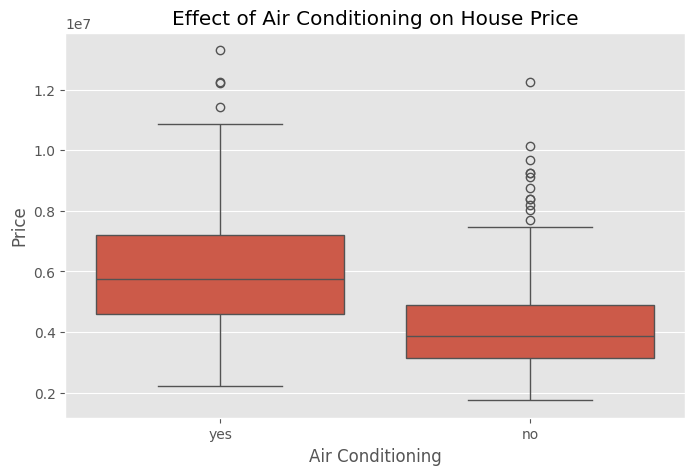

In [8]:
# 4. Impact of Air Conditioning on House Price
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["airconditioning"], y=df["price"])
plt.xlabel("Air Conditioning")
plt.ylabel("Price")
plt.title("Effect of Air Conditioning on House Price")
plt.show()

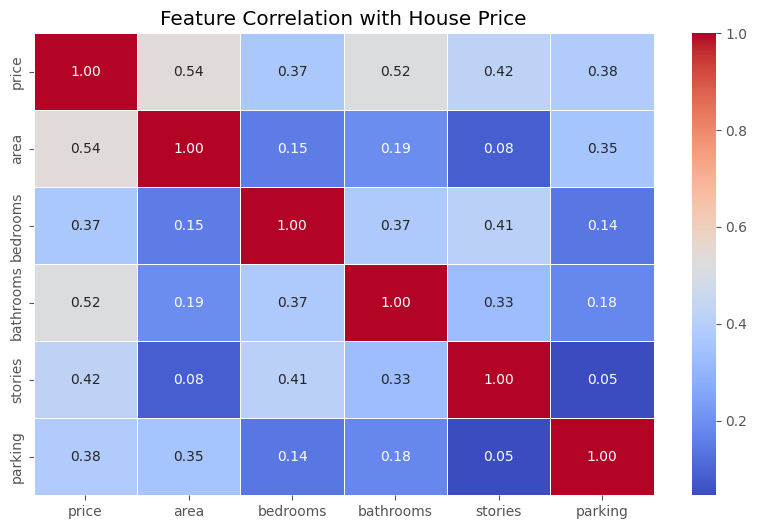

In [9]:
# How much do the following feature correlate
numeric_df = df.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation with House Price")
plt.show()


In [10]:
df.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
5,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished
6,10150000,8580,4,3,4,yes,no,no,no,yes,2,yes,semi-furnished
7,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
8,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished
9,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished


## **Data Preprocessing**

Many machine learning algorithms cannot work directly with categorical data (e.g., `"furnished"`, `"semi-furnished"`, `"unfurnished"`). They require numerical inputs, so we need to transform these categorical values into numbers.

### **One-Hot Encoding**
One approach is **one-hot encoding**, which converts categorical data into a numerical format that machine learning models can process effectively.

For example, consider the `"basement"` category, which contains binary `"yes"` and `"no"` values. Applying one-hot encoding will create two additional columns: `"basement_yes"` and `"basement_no"`.

- If a house **has** a basement, the `"basement_yes"` column will be **1**, and `"basement_no"` will be **0**.
- If a house **does not** have a basement, the `"basement_yes"` column will be **0**, and `"basement_no"` will be **1**.

One drawback of one-hot encoding is that it increases the number of features, which can make training slower, especially for high-cardinality categorical variables (i.e., those with many unique values).

### **Label Encoding**
Another approach is **label encoding**, which replaces categorical values with **numerical labels**. Unlike one-hot encoding, label encoding does **not** create new columns—it **replaces** the original column with numerical values.

For example, in the `"furnishingstatus"` column, which has three categories:

"furnished" → 2 "semi-furnished" → 1 "unfurnished" → 0

Here we will use **Label Encoding** to avoid the limitations of **One-Hot Encoding**.

For **numerical features**, we will apply **standard scaling** using `StandardScaler`, which normalizes data to have **zero mean and unit variance**. This ensures that all numerical features contribute equally to the model.

In [11]:
label_encoders = {}

# Non-numeric columns
categorical_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

# Label Encoding each
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Split data into inputs and desired output
X = data.drop('price', axis=1)
y = data['price']

# Standardize numerical columns
numerical_columns = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X.head(10)

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,1.046726,1.403419,1.421812,1.378217,1,0,0,0,1,1.517692,1,0
1,1.757010,1.403419,5.405809,2.532024,1,0,0,0,1,2.679409,0,0
2,2.218232,0.047278,1.421812,0.224410,1,0,1,0,0,1.517692,1,1
3,1.083624,1.403419,1.421812,0.224410,1,0,1,0,1,2.679409,1,0
4,1.046726,1.403419,-0.570187,0.224410,1,1,1,0,1,1.517692,0,0
5,1.083624,0.047278,3.413810,-0.929397,1,0,1,0,1,1.517692,1,1
6,1.581745,1.403419,3.413810,2.532024,1,0,0,0,1,1.517692,1,1
7,5.096263,2.759560,3.413810,0.224410,1,0,0,0,0,-0.805741,0,2
8,1.360358,1.403419,-0.570187,0.224410,1,1,1,0,1,1.517692,1,0
9,0.276484,0.047278,1.421812,2.532024,1,1,0,0,1,0.355976,1,2


##Training and Testing Using Libraries

Here we will use a model from the SKLearn library.

In [13]:
# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate R^2 and RMSE for training data
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Calculate R^2 and RMSE for test data
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training R^2: {train_r2:,.3f}")
print(f"Training RMSE: {train_rmse:,.2f}")
print(f"Test R^2: {test_r2:,.3f}")
print(f"Test RMSE: {test_rmse:,.2f}")

Training R^2: 0.685
Training RMSE: 984,836.44
Test R^2: 0.649
Test RMSE: 1,331,071.42


## Training and Evaluation Using Equations

Here we will implment the linear regrestion model as discussed in lecture by minimizing Mean Squared Error to verify that we get the same results as the model from SKLearn. This section will also serve to verify the **Gauss-Markov Theorem** stating that the **Ordinary Least Squares** weights for a linear regression model are the **Best Linear Unbiased Estimator,**

In [14]:
# Add bias term to training and test datasets
X_train_bias = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_test_bias = np.c_[np.ones((X_test.shape[0], 1)), X_test]

# Compute weights using OLS
w = np.linalg.inv(X_train_bias.T @ X_train_bias) @ X_train_bias.T @ y_train

# Compute predictions using the learned weights
y_train_pred = X_train_bias @ w
y_test_pred = X_test_bias @ w

# Calculate R^2 and RMSE for training data
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Calculate R^2 and RMSE for test data
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training R^2: {train_r2:.3f}")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test R^2: {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:,.2f}")


Training R^2: 0.685
Training RMSE: 984836.44
Test R^2: 0.649
Test RMSE: 1,331,071.42
